In [1]:
import numpy as np
import scipy.constants
import matplotlib.pyplot as plt

import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
c_light = scipy.constants.c
e_charge = scipy.constants.e

# Parameters

In [3]:
gamma = 9804
# gamma = 9.784756043574142e+03  # Glen

rho = 10.34  # Bend radius in m
LB = 0.5     # Bend length in m

# Desired beam optics at the END of the bend ( see Yunhai's 3D CSR paper )
beta_xf  = 5.19   # in m
alpha_xf = 0
eta_xf   = 0      # in m
etap_xf  = 0

beta_yf  = 12.28   # in m
alpha_yf = 0
eta_yf   = 0      # in m
etap_yf  = 0

# With the parameters above we can calculate (using Bmad)
# the required INITIAL beam optics at the BEGINNING of the bend
beta_x  = 5.22600574   # in m
alpha_x = 0.07195534
eta_x   = 0.01208662     # in m
etap_x  = -0.04833706

beta_y = 12.30035831    # in m
alpha_y = 0.04071661
eta_y   = 0             # in m
etap_y  = 0

# Beam emittance
norm_emit_x = 1e-6           # in m
emit_x = norm_emit_x / gamma # in m
norm_emit_y = 1e-6           # in m
emit_y = norm_emit_y / gamma # in m

# Bunch length and energy spread
sigma_z  = 2e-5
sigma_delta = 5e-5   # a small value picked by Glen


# Total charge
Q = e_charge * 6.25e9


### Checking that Twiss parameter propagation is correct
### $B(s) = M B(0) M^{T}$

In [4]:
gamma_x = (1 + (alpha_x)**2) / beta_x
beta_mat_x = np.array([[beta_x,-alpha_x],[-alpha_x,gamma_x]]) 

transfer_mat_x = np.array([[np.cos(LB/rho),rho*np.sin(LB/rho)],[-np.sin(LB/rho)/rho,np.cos(LB/rho)]])  # bend in the x plane
np.matmul(transfer_mat_x, np.matmul(beta_mat_x,transfer_mat_x.T ))

array([[5.19000000e+00, 1.23635778e-09],
       [1.23635777e-09, 1.92678227e-01]])

In [5]:
gamma_y = (1 + (alpha_y)**2) / beta_y
beta_mat_y = np.array([[beta_y,-alpha_y],[-alpha_y,gamma_y]])  

transfer_mat_y = np.array([[1,LB],[0,1]])  # drift in the y plane
np.matmul(transfer_mat_y, np.matmul(beta_mat_y,transfer_mat_y.T ))

array([[1.22800000e+01, 2.35736360e-09],
       [2.35736360e-09, 8.14332247e-02]])

# Beam definition

In [6]:
# fix random seed 
np.random.seed(0)

# Number of macro particles
Np = 1000000

# charge of one macro-particle
charges = np.ones(Np)*Q/Np  


# Define an uncorrelated beam first
sigma_x = np.sqrt(emit_x * beta_x)
sigma_xp = np.sqrt(emit_x / beta_x)
sigma_y = np.sqrt(emit_y * beta_y)
sigma_yp = np.sqrt(emit_y / beta_y)

beam = np.zeros((6, Np))

beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))
beam[2] = np.random.normal(0, sigma_y , size=(1, Np))
beam[3] = np.random.normal(0, sigma_yp , size=(1, Np))
beam[4] = np.random.normal(0, sigma_z , size=(1, Np))
beam[5] = np.random.normal(0, sigma_delta , size=(1, Np))

## beam[5] = np.zeros(Np)    # turn off initial energy spread

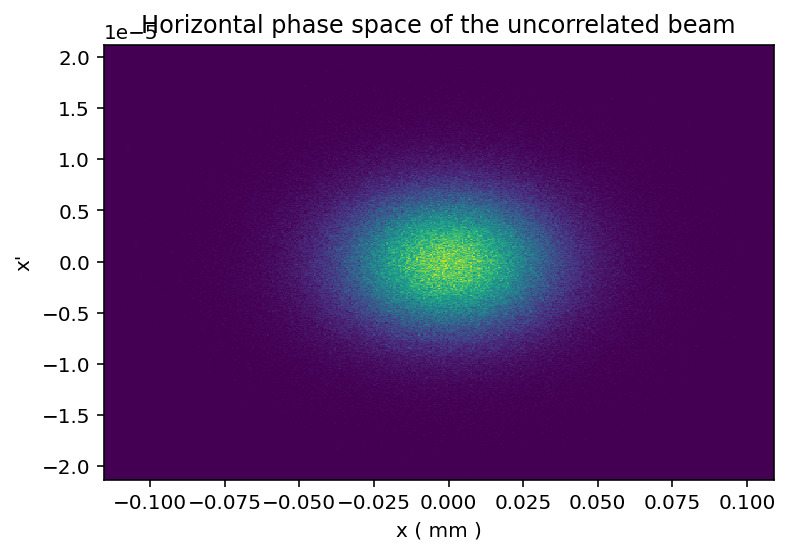

In [7]:
plt.hist2d(beam[0]*1e3,beam[1],bins=(400,400));
plt.xlabel('x ( mm )')
plt.ylabel('x\'')
plt.title('Horizontal phase space of the uncorrelated beam');

In [8]:
# Introduce coupling and dispersion 
r16 = eta_x
r26 = etap_x

r21 = (-1) * (alpha_x / beta_x) 

r36 = eta_y
r46 = etap_y

r43 = (-1) * (alpha_y / beta_y) 

# Apply coupling to the beam
# Be careful with the order of these lines...

beam[1] = beam[1] + r21 * beam[0] + r26 * beam[5]
beam[0] = beam[0] + r16 * beam[5]

beam[3] = beam[3] + r43 * beam[2] + r46 * beam[5]
beam[2] = beam[2] + r36 * beam[5]

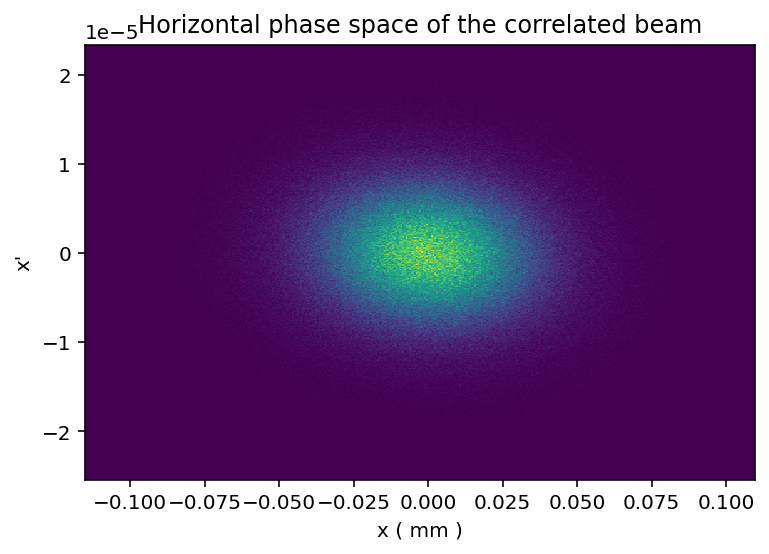

In [9]:
plt.hist2d(beam[0]*1e3,beam[1],bins=(400,400));
plt.xlabel('x ( mm )')
plt.ylabel('x\'')
plt.title('Horizontal phase space of the correlated beam');

## Check emittance

In [10]:
def projected_emit_x(beam):
    SS = np.cov(beam)
    s00 = SS[0][0] - SS[0][5]*SS[0][5] / SS[5][5]
    s01 = SS[0][1] - SS[0][5]*SS[1][5] / SS[5][5]
    s11 = SS[1][1] - SS[1][5]*SS[1][5] / SS[5][5]

    return np.sqrt(s00*s11 - s01**2)

In [11]:
print(emit_x)          # desired
projected_emit_x(beam) # from the beam

1.0199918400652795e-10


1.0187762619965148e-10

### Additional parameters 

In [ ]:
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
P0c = gamma * beta * mc2  # in eV

# overtaking distance ( for Tao )
L0 = (24*sigma_z*rho**2)**(1/3)

# Characteristic wake in eV/m from Chris's paper
W0 = 1e9* 2.8179403227E-15 * 510998.950 *(sigma_z/rho)**(2/3) / sigma_z**2